# Basic Neural Machine Translation for English to Marathi Language Translation

- Machine translation is a challenging task that traditionally involves large statistical models developed using highly sophisticated linguistic knowledge. Neural machine translation is the use of deep neural networks for the problem of machine translation.

- We will develop a basic neural machine translation system for translating English phrases to Marathi. This tutorial is divided into 2 parts which are:

    - Preparing the Textual Data
    - Building & Evaluating the Neural Machine Translation Model


In [1]:
# import necessary libraries
import re
import string
from unicodedata import normalize
import numpy as np
from pickle import dump, load
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu

# print tensorflow version
print(f'TensorFlow Version is {tf.__version__}')

TensorFlow Version is 2.2.0


### English to Marathi Translation Dataset
- The dataset is available from [ManyThings.org](http://www.manythings.org/) website. The page provides a list of many language pairs and we will use Marathi - English [(mar-eng.zip)](http://www.manythings.org/anki/mar-eng.zip) dataset.

In [2]:
# download the dataset
!wget http://www.manythings.org/anki/mar-eng.zip

--2020-06-21 19:08:39--  http://www.manythings.org/anki/mar-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 172.67.173.198, 104.24.108.196, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1242995 (1.2M) [application/zip]
Saving to: ‘mar-eng.zip’

mar-eng.zip         100%[===================>]   1.18M   963KB/s    in 1.3s    

2020-06-21 19:08:42 (963 KB/s) - ‘mar-eng.zip’ saved [1242995/1242995]



In [3]:
# unzip the downloaded file
!unzip mar-eng.zip

Archive:  mar-eng.zip
  inflating: mar.txt                 
  inflating: _about.txt              


- Once we decompress the file it will contain 38,696 pairs of English and Marathi phrases, one pair per line with a tab separating the language. We can ignore the third column in the dataset which is not relevant for our translation task.

In [0]:
# view first 5 lines of data
with open('mar.txt', encoding='utf-8') as f:
    for _ in range(5):
        l = f.readline()
        print(l)

Go.	जा.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #3138228 (sabretou)

Run!	पळ!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #3138217 (sabretou)

Run!	धाव!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #3138218 (sabretou)

Run!	पळा!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #3138219 (sabretou)

Run!	धावा!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #3138220 (sabretou)



- We will frame the prediction problem as given a sequence of words in English as input, translate or predict the sequence of words in Marathi.

## Prepare the Textual Data
- The next step is to prepare the textual data for modeling. If you are new to cleaning text data, see this post :- [How to Clean Text for Machine Learning with Python](https://machinelearningmastery.com/clean-text-machine-learning-python/)

- After reviewing the raw data here are some observations:
    - There are punctuations.
    - The text contains uppercase and lowercase letters.
    - There are special characters in Marathi phrases.
    - There are duplicate phrases in English with different translations in Marathi.
    - The file is ordered by sentence length with very long sentences toward the end of the file.

- Data preparation is divided into 3 subsections:
    1. Clean Text
    2. Split Text
    3. Tokenize and Encode the Text

### 1. Clean Text
- First, we must load the data in a way that preserves the Unicode Marathi characters. The function below called clean_text( ) will load the file as a blob of text. We will read the file using **UTF-8** encoding and write the pairs to a new file called 'eng-mar.txt' discarding the third column value.

In [0]:
# load and clean the text
def clean_text(filename):
    with open(filename, mode='rt', encoding='utf-8') as f:
        with open('eng-mar.txt', mode='wt', encoding='utf-8') as t:
            for line in f:
                line = line.split('	CC', 1)[0]
                t.write(''.join(line))
                t.write('\n')

clean_text('mar.txt')

In [0]:
# view first 5 lines of cleaned text
with open('eng-mar.txt', encoding='utf-8') as f:
    for _ in range(5):
        l = f.readline()
        print(l)

Go.	जा.

Run!	पळ!

Run!	धाव!

Run!	पळा!

Run!	धावा!



- We must first read the data in a way that preserves the Unicode Marathi characters. The function below called read_text( ) will load the file as a blob of text.

In [0]:
# load the clean text
def read_text(filename):
    # open file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read the text
    text = file.read()
    # close the file
    file.close
    return text

text = read_text('eng-mar.txt')

- Each line contains a single pair of phrases first English and then Marathi separated by a tab character. We must split the loaded text by line and then by phrase. The function to_pairs( ) below will split the loaded text.

In [0]:
# split text into sentences
def to_pairs(text):
    # split test by line
    lines = text.strip().split('\n')
    # split text by phrase
    pairs = [line.split('\t') for line in lines]
    return pairs

pairs = to_pairs(text)

In [7]:
## check out first 10 pairs
pairs[:10]

[['Go.', 'जा.'],
 ['Run!', 'पळ!'],
 ['Run!', 'धाव!'],
 ['Run!', 'पळा!'],
 ['Run!', 'धावा!'],
 ['Who?', 'कोण?'],
 ['Wow!', 'वाह!'],
 ['Fire!', 'आग!'],
 ['Fire!', 'फायर!'],
 ['Help!', 'वाचवा!']]

- We are now ready to clean each sentence. The specific cleaning operations we will perform are as follows:

    * Remove all non-printable characters.
    * Remove all punctuation characters.
    * Normalize all Unicode characters to ASCII (e.g. Latin characters).
    * Normalize the case to lowercase.
    * Remove any remaining tokens that are not alphabetic.

- We will perform these operations on each phrase for each pair in the loaded dataset. The clean_pairs( ) function below implements these operations.

- __[string.printable](https://docs.python.org/3/library/string.html#string.printable)__

    * String of ASCII characters which are considered printable. This is a combination of digits, ascii_letters, punctuation, and whitespace.

- __[unicodedata](https://docs.python.org/3.8/library/unicodedata.html)__

    - __unicodedata.normalize(form, unistr)__

        * Returns the normal form for the Unicode string unistr. Valid values for form are ‘NFC’, ‘NFKC’, ‘NFD’, and ‘NFKD’.
        * Normal form D (NFD) is also known as canonical decomposition and translates each character into its decomposed form.

- __[Standard Encodings](https://docs.python.org/3/library/codecs.html#standard-encodings)__

- __[bytes.decode](https://docs.python.org/3/library/stdtypes.html#bytes.decode)__

In [0]:
def clean_pairs(pairs):
    cleaned = list()
    # prepare regex for char filtering
    #re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translaion table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in pairs:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode()
            # for english language
            #line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode()
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars from each token
            #line = [re_print.sub('', word) for word in line]
            # remove tokens with numbers in them
            #line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return np.array(cleaned)

clean_pairs = clean_pairs(pairs)

- Now that the data has been cleaned, we can save the list of phrase pairs to a file ready for use. The function save_clean_data( ) uses the pickle API to save the list of clean text to file.

In [9]:
# save list of clean sentences to file
def save_clean_data(clean_pairs, filename):
    dump(clean_pairs, open(filename, mode='wb'))
    print(f'Saved : {filename}')

save_clean_data(clean_pairs, 'eng-mar-both.pkl')

Saved : eng-mar-both.pkl


In [10]:
# spot check
for i in range(5):
    print(f'{clean_pairs[i,0]} ==> {clean_pairs[i,1]}')

go ==> जा
run ==> पळ
run ==> धाव
run ==> पळा
run ==> धावा


### 2. Split Text
- We will first load the dataset, shuffle and then split it into training and testing set. We will utilize the first 35000 pairs as training data from the shuffled dataset and rest as testing data.

In [0]:
# load clean dataset
def load_clean_dataset(filename):
    return load(open(filename, mode='rb'))

dataset = load_clean_dataset('eng-mar-both.pkl')

In [0]:
# checkout the dataset
dataset

array([['go', 'जा'],
       ['run', 'पळ'],
       ['run', 'धाव'],
       ...,
       ['tom tried to sell his old vcr instead of throwing it away but no one would buy it so he ended up throwing it away',
        'टॉमने त्याचा जुना व्हीसीआर फेकून टाकण्याऐवजी विकून टाकण्याचा प्रयत्न केला पण विकत घ्यायला कोणीच तयार नव्हतं म्हणून त्याला तो शेवटी फेकूनच टाकायला लागला'],
       ['you cant view flash content on an ipad however you can easily email yourself the urls of these web pages and view that content on your regular computer when you get home',
        'आयपॅडवर फ्लॅश आशय बघता येत नाही पण तुम्ही त्या वेब पानांचे यूआरएल स्वतःला ईमेल करून तोच आशय घरी पोहोचल्यावर आपल्या रोजच्या संगणकावर पाहू शकता'],
       ['in 1969 roger miller recorded a song called you dont want my love today this song is better known as in the summer time its the first song he wrote and sang that became popular',
        '१९६९मध्ये रॉजर मिलरने यू डोन्ट वॉन्ट माय लव्ह नावाचं गाणं रेकॉर्ड केलं आज हे गाणं इन द समर टाइम म्हणू

In [0]:
# random shuffle
np.random.shuffle(dataset)

# split the data into training and testing set
train_data, test_data = dataset[:35000], dataset[35000:]

### 3.1 Tokenize the Text

- We will use the Keras Tokenize class to map words to integers. We will use separate tokenizer for English and Marathi sequences. The function below create_tokenizer( ) will tokenize the phrases.

In [0]:
# create tokenizer
def create_tokenizer(data):
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(data)
    return tokenizer

- Similarly, the function max_length( ) below will find the length of the longest sentence in the list of phrases.

In [0]:
# get maximum sentence length
def max_length(data):
    return max(len(line.split()) for line in data)

In [0]:
# tokenize english phrases
eng_tokenizer = create_tokenizer(dataset[:, 0])
# get size of english vocabulary
eng_vocab_size = len(eng_tokenizer.word_index) + 1
print(f'English Vocabulary Size : {eng_vocab_size}')
# get maximum length of a phrase in english
eng_length = max_length(dataset[:, 0])
print(f'Maximum length of a Sentence in English : {eng_length}')

# tokenize marathi phrases
mar_tokenizer = create_tokenizer(dataset[:, 1])
# get size of marathi vocabulary
mar_vocab_size = len(mar_tokenizer.word_index) + 1
print(f'Marathi Vocabulary Size : {mar_vocab_size}')
# get maximum length of a phrase in marathi
mar_length = max_length(dataset[:, 1])
print(f'Maximum length of a Sentence in Marathi : {mar_length}')

English Vocabulary Size : 5763
Maximum length of a Sentence in English : 35
Marathi Vocabulary Size : 13565
Maximum length of a Sentence in Marathi : 35


### 3.2 Encode the Textual Data
- Each input and output sequence must be encoded to integers and padded to the maximum phrase length. This is because we will use a word embedding for the input sequences. The function below named encode_sequences( ) will perform this operation and return the result.

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, data):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(data)
    # pad sequences with zero values
    X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=length, padding='post')
    return X

- The output sequence needs to be one-hot encoded. This is because the model will predict the probability of each word in the vocabulary as output. The function encode_output( ) below will one-hot encode Marathi output sequences.

In [0]:
# one hot encode target sequence
#def encode_output(sequences, vocab_size):
#    ylist = list()
#    for sequence in sequences:
#        encoded = tf.keras.utils.to_categorical(sequence, num_classes=vocab_size)
#        ylist.append(encoded)
#    y = np.array(ylist)
#    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
#    return y

In [0]:
# encode training data
X_train = encode_sequences(eng_tokenizer, eng_length, train_data[:, 0])
Y_train = encode_sequences(mar_tokenizer, mar_length, train_data[:, 1])
#Y_train = encode_output(Y_train, eng_vocab_size)

# encode testing data
X_test = encode_sequences(eng_tokenizer, eng_length, test_data[:, 0])
Y_test = encode_sequences(mar_tokenizer, mar_length, test_data[:, 1])
#Y_test = encode_output(Y_test, eng_vocab_size)

## Define Neural Machine Translation Model

* We will use an encoder-decoder LSTM model for this task. In this architecture, the input sequence is encoded by a front-end model called the encoder then decoded word by word by a backend model called the decoder.

* The function define_model( ) below defines the model and takes a number of arguments used to configure the model, such as the size of the input and output vocabularies, the maximum length of input and output phrases and the number of memory units used to configure the model.

In [0]:
# define NMT model
def define_model(src_vocab_size, tar_vocab_size, src_length, tar_length, units):
    model = tf.keras.models.Sequential()
    # define encoder
    model.add(tf.keras.layers.Embedding(src_vocab_size, units, input_length=src_length, mask_zero=True))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=units, dropout=0.4)))
    # define decoder
    model.add(tf.keras.layers.RepeatVector(n=tar_length))
    model.add(tf.keras.layers.LSTM(units=units, return_sequences=True, dropout=0.4))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(tar_vocab_size, activation='softmax')))
    return model

model = define_model(eng_vocab_size, mar_vocab_size, eng_length, mar_length, units=512)

# get model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 512)           2950656   
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              4198400   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 35, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 35, 512)           3147776   
_________________________________________________________________
time_distributed (TimeDistri (None, 35, 13565)         6958845   
Total params: 17,255,677
Trainable params: 17,255,677
Non-trainable params: 0
_________________________________________________________________


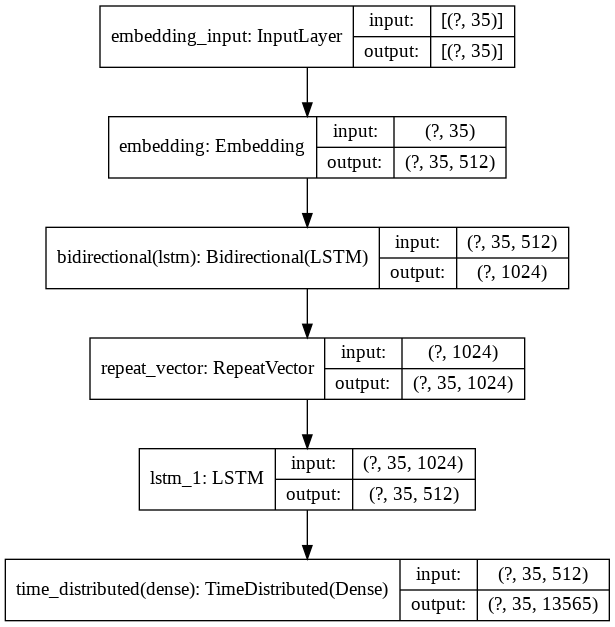

In [0]:
# plot the model
tf.keras.utils.plot_model(model, to_file='basic_nmt.png', show_shapes=True)

* The model is trained using the efficient Adam approach to stochastic gradient descent and minimizes the sparse categorical loss function because we have framed the prediction problem as multi-class classification.

* Please note that we have used *'sparse_categorical_crossentropy'* as the loss function because it allows us to use the target sequence as is instead of one hot encoding. One hot encoding the target sequences with such a huge vocabulary will consume our system's entire memory.

* We will use Earlystopping to monitor 'val_loss' with a patience of 3 to stop traning if there is no improvement for 3 consecutive epochs. We will also use Model Checkpoint to ensure that each time the model skill on the test set improves, the model is saved.

* We train the model for 30 epochs with a batch size of 64.

In [0]:
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# define early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

# define model checkpoint
mckpt = tf.keras.callbacks.ModelCheckpoint('nmt_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# define Reduce Learning Rate on Plateau
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.15, patience=3, verbose=1, mode='min')

# fit the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=64, callbacks=[es, mckpt])

Epoch 1/30
547/547 [==============================] - ETA: 0s - loss: 1.1208
Epoch 00001: val_loss improved from inf to 0.93111, saving model to nmt_model.h5
547/547 [==============================] - 103s 188ms/step - loss: 1.1208 - val_loss: 0.9311
Epoch 2/30
547/547 [==============================] - ETA: 0s - loss: 0.8940
Epoch 00002: val_loss improved from 0.93111 to 0.86772, saving model to nmt_model.h5
547/547 [==============================] - 101s 184ms/step - loss: 0.8940 - val_loss: 0.8677
Epoch 3/30
547/547 [==============================] - ETA: 0s - loss: 0.8103
Epoch 00003: val_loss improved from 0.86772 to 0.79355, saving model to nmt_model.h5
547/547 [==============================] - 100s 184ms/step - loss: 0.8103 - val_loss: 0.7936
Epoch 4/30
547/547 [==============================] - ETA: 0s - loss: 0.7218
Epoch 00004: val_loss improved from 0.79355 to 0.72077, saving model to nmt_model.h5
547/547 [==============================] - 100s 184ms/step - loss: 0.7218 - v

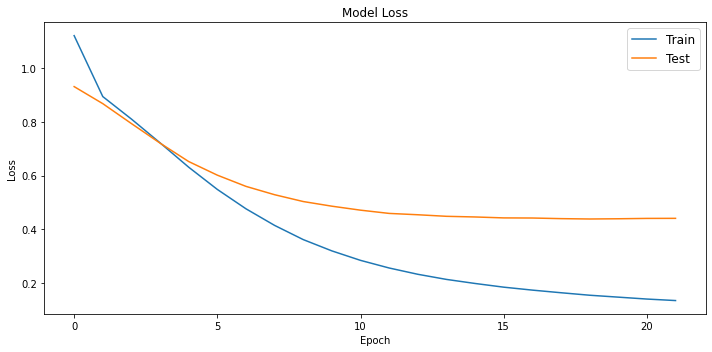

In [0]:
# Plot Model Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(labels=['Train', 'Test'], fontsize='large')
plt.tight_layout()

### Evaluate Neural Machine Translation Model

* Evaluation involves two steps: first generating a translated output sequence and then repeating this process for many input examples and summarizing the skill of the model across multiple cases.

* Starting with inference, the model can predict the entire output sequence in a one-shot manner. This will be a sequence of integers that we can enumerate and lookup in the tokenizer to map back to words. The function below named word_for_id( ) will perform this reverse mapping.


In [0]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

* We can perform this mapping for each integer in the translation and return the result as a string of words. The function predict_sequence( ) below performs this operation for a single encoded source phrase.

* Next, we can repeat this for each source phrase in a dataset and compare the predicted result to the expected target phrase in Marathi.

In [0]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

* We will also calculate the BLEU scores to get a quantitative idea of how well the model has performed. You can learn more about the BLEU score here :- [Calculating the BLEU Score for Text in Python](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/).

* The evaluate_model( ) function below implements this calling the above predict_sequence() function for each phrase in a provided dataset. Running the function first prints examples of source text, target text and predicted translations as well as BLEU scores for the test dataset.

* Looking at the results for the test dataset, we can see that the translations are readable and fairly accurate.

* We can also see that the translations were not perfect and can be improved with [Attention Mechanism](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) which we will see in another tutorial.

In [0]:
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, tokenizer, source)
        src, target = dataset[i]
        if i < 20:
            print(f'src ===> {src};  target ===> {target};  translated ===> {translation}')
        
        actual.append([target.split()])
        predicted.append(translation.split())
    # calculate BLEU score
    print('=='*50)
    print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
    print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')
    print(f'BLEU-3: {corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))}')
    print(f'BLEU-4: {corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))}')

# test on some test sequences
evaluate_model(model, mar_tokenizer, X_test, test_data)

src ===> whats your name;  target ===> तुमचं नाव काय आहे;  translated ===> तुमचं नाव काय आहे
src ===> our website is offline for scheduled maintenance;  target ===> आमचे संकेतस्थळ नियोजित देखरेखीकरिता ऑफलाइन आहे;  translated ===> आमची देशाचा नाव क्रमांक करून आहे
src ===> someone will close the window;  target ===> कोणीतरी खिडकी बंद करेल;  translated ===> कोणीतरी कोणीतरी बघेल
src ===> she bit him;  target ===> तिने त्यांना चावलं;  translated ===> त्यांनी त्याला चावलं
src ===> i can teach you how to sing;  target ===> मी तुम्हाला गायला शिकवू शकतो;  translated ===> मी तुला गायला शिकवू शकते
src ===> the potatoes stayed hot;  target ===> बटाटे गरम राहिले;  translated ===> सँडविच सँडविच बिघडला
src ===> is that black bag yours;  target ===> ती काळी बॅग तुमची आहे का;  translated ===> ती काळी पिशवी तुमची आहे का
src ===> japan is a rich country;  target ===> जपान श्रीमंत देश आहे;  translated ===> जपान हा जुना देश आहे
src ===> call the number i gave you;  target ===> मी तुला दिलेल्या नंबरवर फोन क

[Configuration of Encoder-Decoder Model for NMT](https://machinelearningmastery.com/configure-encoder-decoder-model-neural-machine-translation/)

[Basic Neural Machine Translation](https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/)